## POSTPROECESSING

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install leidenalg==0.7.0

In [3]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from MODULES.utilities import load_obj
import torch
import numpy
import skimage.color
import torch.nn.functional as F
from MODULES.graph_clustering import *
import time
from typing import List, Tuple

## Helper function

In [4]:
def show_sweep_movie(suggestion: Suggestion,
                     raw_image: numpy.ndarray,
                     figsize: Tuple[int,int] = (12,12),
                     interval: int = 50,
                     nbins=10,
                     hist_range=(0,200)):
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
    ax_video = axs[0,0]
    ax_image = axs[0,1]
    ax_graph = axs[1,0]
    ax_hist = axs[1,1]
    
    # image
    ax_video.axis('off')
    im = ax_video.imshow(skimage.color.label2rgb(suggestion.sweep_seg_mask[0, ...], bg_label=0), aspect='equal')
    ax_video.set_title("title")

    # reference image
    ax_image.axis('off')
    _ = ax_image.imshow(raw_image, cmap='gray', aspect='equal')
    
    # graph
    color = 'tab:red'
    _ = ax_graph.plot(suggestion.sweep_resolution, suggestion.sweep_n_cells, '.--', label="n_cell", color=color)
    ax_graph.set_xlabel("resolution")
    ax_graph.set_ylabel('n_cell', color=color)
    ax_graph.tick_params(axis='y', labelcolor=color)
    ax_graph.legend()
    ax_graph.grid()

    ax_graph_2 = ax_graph.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:green'
    _ = ax_graph_2.plot(suggestion.sweep_resolution, suggestion.sweep_iou, '-', label="iou", color=color)
    ax_graph_2.set_ylabel('iou', color=color)
    ax_graph_2.tick_params(axis='y', labelcolor=color)
    ax_graph_2.legend()
    
    # histogram of sizes (excluding background cluster)
    _ = ax_hist.hist(suggestion.sweep_sizes[0][1:], range=hist_range, density=False, bins=nbins)
    ax_hist.set_title("title")
        
    plt.tight_layout()
    plt.close()
    
    def init():
        im.set_data(suggestion.sweep_seg_mask[0, ...])
        ax_video.set_title("title")
        ax_hist.hist(suggestion.sweep_sizes[0][1:], range=hist_range, density=False, bins=nbins)
        
    def animate(i):
        title = 'index={0:3d} res={1:.3f} ncell={2:2d}'.format(i,suggestion.sweep_resolution[i],
                                                                 suggestion.sweep_n_cells[i])
        ax_video.imshow(skimage.color.label2rgb(suggestion.sweep_seg_mask[i, ...], bg_label=0))
        ax_video.set_title(title)
        ax_hist.clear()
        ax_hist.hist(suggestion.sweep_sizes[i][1:], range=hist_range, density=False, bins=nbins)
        ax_hist.set_title("PDF cell size")
        
    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=suggestion.sweep_seg_mask.shape[0],
        interval=interval)
    
    return HTML(anim.to_html5_video())

def plot_sweep_comparison(keys: str, 
                          sweep1: Suggestion, 
                          sweep2: Optional[Suggestion] = None, 
                          sweep3: Optional[Suggestion] = None,
                          sweep4: Optional[Suggestion] = None,
                          index: Optional[int] = None,
                          **kargs):
    """ kargs can include:
        density=True, bins=50, range=(10,100)
    """
    
    fig, axs = plt.subplots(figsize=(12,6))
    
    if keys == "sweep_sizes":
        assert index is not None
        n = len(getattr(sweep1,keys))
        axs.set_title("Sizes fo the foreground objects")
        
        tmp = numpy.array((getattr(sweep1,keys)[index][1:],
                        getattr(sweep2,keys,[-100,-100]*n)[index][1:],
                        getattr(sweep3,keys,[-100,-100]*n)[index][1:],
                        getattr(sweep4,keys,[-100,-100]*n)[index][1:]), dtype=object, copy=False)

        _ = axs.hist(tmp, label=["sweep1","sweep2","sweep3","sweep4"], **kargs)
        axs.legend()
        axs.set_xlabel('resolution parameter')
        axs.set_ylabel(keys)
        
        axs.grid()
        axs.legend()
        
        
    else:
        # all the rest is separate
        axs.plot(sweep1.sweep_resolution,getattr(sweep1,keys), '-', label="sweep1",color="blue")
        if sweep2 is not None:
            axs.plot(sweep2.sweep_resolution,getattr(sweep2,keys), 'x--', label="sweep2",color="red")
        if sweep3 is not None:
            axs.plot(sweep3.sweep_resolution,getattr(sweep3,keys), 'o-', label="sweep3",color="green")
        if sweep4 is not None:
            axs.plot(sweep4.sweep_resolution,getattr(sweep4,keys), '.--', label="sweep4",color="black")
        
        axs.set_xlabel('resolution parameter')
        axs.set_ylabel(keys)
        axs.grid()
        axs.legend()

In [5]:
def plot_mask_image_overlay(seg_mask: numpy.ndarray, 
                            raw_image: numpy.ndarray, 
                            window: Optional[tuple] = None, 
                            figsize: tuple = (24,24)):
    
    assert seg_mask.shape[:2] == raw_image.shape[:2]
    
    if window is not None:
        min_row, min_col, max_row, max_col = window 
        seg_mask = seg_mask[min_row:max_row, min_col:max_col]
        raw_image = raw_image[min_row:max_row, min_col:max_col]
    
    figure, ax = plt.subplots(ncols=3, figsize=figsize)
    ax[0].imshow(skimage.color.label2rgb(label=seg_mask, bg_label=0))
    ax[1].imshow(skimage.color.label2rgb(label=seg_mask, image=raw_image, alpha=0.25, bg_label=0))
    ax[2].imshow(raw_image, cmap='gray')

In [6]:
def plot_mask_with_contours(segmask, raw_image, figsize: tuple =(24,24)):
    n = numpy.max(segmask)
    print(n)
    figure, ax = plt.subplots(ncols=3, figsize=figsize)
    ax[0].imshow(raw_image, cmap='gray')
    #ax[0].imshow(skimage.color.label2rgb(label=segmask, image=raw_image, alpha=0.25, bg_label=0))
    ax[1].contour(segmask,levels=0.5+numpy.arange(n), origin=None, linewidths=2, colors='red', alpha=1.0)
    ax[1].imshow(raw_image, cmap='gray')
    ax[2].imshow(segmask, cmap='gray')

In [7]:
def plot_tiling(tiling: Segmentation, 
                window: Optional[tuple] = None, 
                figsize: tuple = (24,24)):
    
    if window is None:
        min_row, min_col, max_row, max_col = None, None, None, None
    else:
        min_row, min_col, max_row, max_col = window 
        
    fig, axs = plt.subplots(ncols=3, figsize=figsize)
    axs[0].imshow(tiling.raw_image[0,0,min_row:max_row, min_col:max_col].cpu())
    axs[1].imshow(tiling.fg_prob[0,0,min_row:max_row, min_col:max_col].cpu())
    axs[2].imshow(skimage.color.label2rgb(tiling.integer_mask[0,0,min_row:max_row, min_col:max_col].cpu().numpy(), bg_label=0), aspect='equal')
    axs[0].set_title("raw image")
    axs[1].set_title("fg prob")
    axs[2].set_title("sample segmentation")

# Import files

In [8]:
#tiling_file = "/home/jupyter/REPOS/spacetx-research/NEW_ARCHIVE/merfish_aug_5_v1/tiling_aug7_radius5.pt"
#tiling_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/merfish_aug_5_v1/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_12_v2/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_segment_june27_v2/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_12_v6/tiling.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_17_v1/tiling_3100.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_17_v1/tiling_3100_LARGE.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_18_v1/tiling_17500_SMALL.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_18_v1/tiling_17500_LARGE.pt"
#tiling_file = "NEW_ARCHIVE/merfish_aug_19_v1/tiling_SMALL.pt"
tiling_file = "NEW_ARCHIVE/merfish_aug_19_v1/tiling_LARGE.pt"
tiling = load_obj(tiling_file)

# Comparison of criteria using small images

In [ ]:
window = (1000, 2100, 1300, 2400)
#window = None
plot_tiling(tiling, window)

### Graph with normalization

In [ ]:
g1 = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=True)
print(g1.graph["total_nodes"])
print(g1.graph["total_edge_weight"])

In [ ]:
sweep_cpm1 = g1.suggest_resolution_parameter(window = window, 
                                             min_size = 20,
                                             max_size = None,
                                             cpm_or_modularity = "cpm",
                                             each_cc_separately = False,
                                             sweep_range = numpy.arange(1.0,20.0,1.0)) 
sweep_modularity1 = g1.suggest_resolution_parameter(window = window, 
                                                  min_size = 20,
                                                  max_size = None,
                                                  cpm_or_modularity = "modularity",
                                                  each_cc_separately = False,
                                                  sweep_range = numpy.arange(1.0,20.0,1.0)) 

In [ ]:
#sweep_cpm1.show_graph(figsize=(12,12))
#sweep_modularity1.show_graph(figsize=(12,12))
#sweep_modularity1.show_best()
#sweep_cpm1.show_best()

### Graph without normalization

In [ ]:
g2 = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=False)
print(g2.graph["total_nodes"])
print(g2.graph["total_edge_weight"])

In [ ]:
sweep_cpm2 = g2.suggest_resolution_parameter(window = window, 
                                             min_size = 20,
                                             max_size = None,
                                             cpm_or_modularity = "cpm",
                                             each_cc_separately = False,
                                             sweep_range = numpy.arange(1.0,20.0,1.0)) 
sweep_modularity2 = g2.suggest_resolution_parameter(window = window, 
                                                  min_size = 20,
                                                  max_size = None,
                                                  cpm_or_modularity = "modularity",
                                                  each_cc_separately = False,
                                                  sweep_range = numpy.arange(1.0,20.0,1.0)) 

# Compare sweeps by graphs 

In [ ]:
sweep_cpm1._fields

In [ ]:
plot_sweep_comparison('sweep_sizes', sweep_cpm1, sweep_cpm2, sweep_modularity1, sweep_modularity2, index=-1, bins=25)

In [ ]:
plot_sweep_comparison('sweep_iou', sweep_cpm1, sweep_cpm2, sweep_modularity1, sweep_modularity2)

In [ ]:
plot_sweep_comparison('sweep_n_cells', sweep_cpm1, sweep_cpm2, sweep_modularity1, sweep_modularity2)

# Compare sweeps by movie

In [ ]:
if window is None:
    raw_image = tiling.raw_image[0,0].cpu().numpy()
else:
    raw_image = tiling.raw_image[0,0,window[0]:window[2],window[1]:window[3]].cpu().numpy()

In [ ]:
show_sweep_movie(suggestion=sweep_cpm1,
                 raw_image=raw_image,
                 figsize= (12, 12),
                 interval= 500,
                 nbins=20,
                 hist_range=(0,300))

In [ ]:
show_sweep_movie(suggestion=sweep_modularity1,
                 raw_image=raw_image,
                 figsize= (12, 12),
                 interval= 500,
                 nbins=20,
                 hist_range=(0,300))

In [ ]:
show_sweep_movie(suggestion=sweep_cpm2,
                 raw_image=raw_image,
                 figsize= (12, 12),
                 interval= 500,
                 nbins=20,
                 hist_range=(0,300))

In [ ]:
show_sweep_movie(suggestion=sweep_modularity2,
                 raw_image=raw_image,
                 figsize= (12, 12),
                 interval= 500,
                 nbins=20,
                 hist_range=(0,300))

# Compare sweep by segmentation

In [ ]:
#sweep_cpm2.show_graph(figsize=(12,12))
#sweep_modularity2.show_graph(figsize=(12,12))
#sweep_modularity2.show_best()
#sweep_cpm2.show_best()

In [ ]:
index=-10
print(sweep_modularity1.sweep_resolution[index])
plot_mask_image_overlay(seg_mask=sweep_modularity1.sweep_seg_mask[index],
                        raw_image=raw_image, 
                        window=None, 
                        figsize=(24,24))

In [ ]:
plot_mask_image_overlay(seg_mask=sweep_modularity2.sweep_seg_mask[-1],
                        raw_image=raw_image, 
                        window=None, 
                        figsize=(24,24))

In [ ]:
plot_mask_image_overlay(seg_mask=sweep_cpm1.sweep_seg_mask[-1],
                        raw_image=raw_image, 
                        window=None, 
                        figsize=(24,24))

In [ ]:
plot_mask_image_overlay(seg_mask=sweep_cpm2.sweep_seg_mask[-1],
                        raw_image=raw_image, 
                        window=None, 
                        figsize=(24,24))

### Chose the best and visualize

In [ ]:
sweep_modularity1.show_index(index=-10, figsize=(12,12))

In [ ]:
if window is None:
    raw_image = tiling.raw_image[0,0].cpu().numpy()
else:
    raw_image = tiling.raw_image[0,0,window[0]:window[2],window[1]:window[3]].cpu().numpy()

In [ ]:
index=-10
print("resolution",sweep_modularity1.sweep_resolution[index])
plot_mask_image_overlay(seg_mask=sweep_modularity1.sweep_seg_mask[index],
                        raw_image=raw_image, 
                        window=None, 
                        figsize=(24,24))

In [ ]:
index=-1
print("resolution",sweep_modularity1.sweep_resolution[index])
plot_mask_image_overlay(seg_mask=sweep_modularity1.sweep_seg_mask[index],
                        raw_image=raw_image, 
                        window=None, 
                        figsize=(24,24))

# Now run segmentation on the entire image

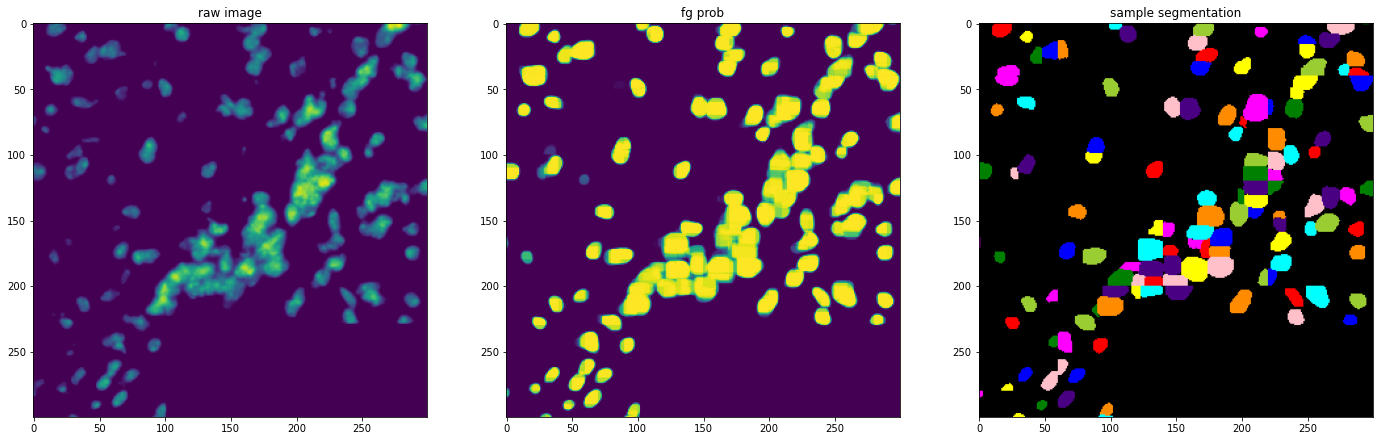

In [35]:
window = None
window = (1000, 2100, 1300, 2400)

plot_tiling(tiling, window)

In [10]:
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=True)

Done building the graph


In [11]:
print(g.graph["total_nodes"])
print(g.graph["total_edge_weight"])
g.graph.summary()

767824
368471.0625


'IGRAPH U-W- 767824 66623487 -- \n+ attr: total_edge_weight (g), total_nodes (g), label (v), weight (e)'

In [67]:
start_time = time.time()
window = None
#window = (1000, 2100, 1300, 2400)

partition = g.find_partition_leiden(resolution=500.0, 
                                    window=window,
                                    min_size=30, 
                                    cpm_or_modularity="modularity", 
                                    each_cc_separately=False,
                                    n_iterations=10,
                                    initial_membership=None) #initial_membership=g._partition_connected_components)
print("community detection time",time.time()-start_time)

find partition internal
end find partition internal 11.689565420150757
community detection time 12.426238775253296


In [68]:
window = (1000, 2100, 1300, 2400)

if window is None:
    raw_image = tiling.raw_image[0,0].cpu().numpy()
    segmask = g.partition_2_mask(partition).cpu().numpy()
    sample_segmax =  tiling.integer_mask[0,0].cpu().numpy()
else:
    raw_image = tiling.raw_image[0,0].cpu().numpy()[window[0]:window[2],window[1]:window[3]]
    segmask = g.partition_2_mask(partition).cpu().numpy()[window[0]:window[2],window[1]:window[3]]
    sample_segmax =  tiling.integer_mask[0,0].cpu().numpy()[window[0]:window[2],window[1]:window[3]]

102


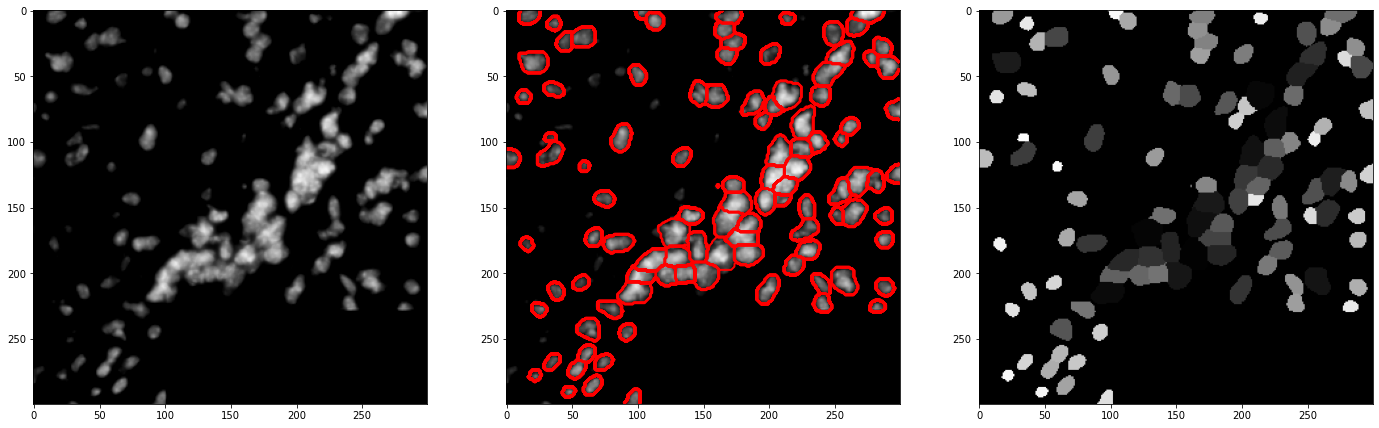

In [69]:
plot_mask_with_contours(segmask, raw_image)

In [36]:
#window = (1000, 2100, 1300, 2400)

if window is None:
    raw_image = tiling.raw_image[0,0].cpu().numpy()
    segmask = g.partition_2_mask(partition).cpu().numpy()
    sample_segmax =  tiling.integer_mask[0,0].cpu().numpy()
else:
    raw_image = tiling.raw_image[0,0].cpu().numpy()[window[0]:window[2],window[1]:window[3]]
    segmask = g.partition_2_mask(partition).cpu().numpy()[window[0]:window[2],window[1]:window[3]]
    sample_segmax =  tiling.integer_mask[0,0].cpu().numpy()[window[0]:window[2],window[1]:window[3]]

2577


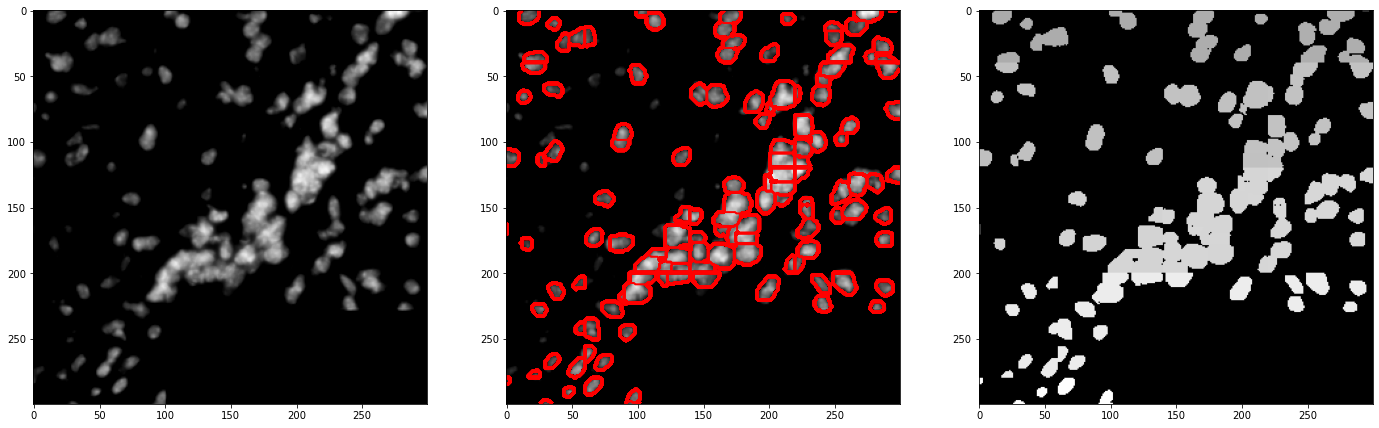

In [37]:
plot_mask_with_contours(sample_segmax, raw_image)

100


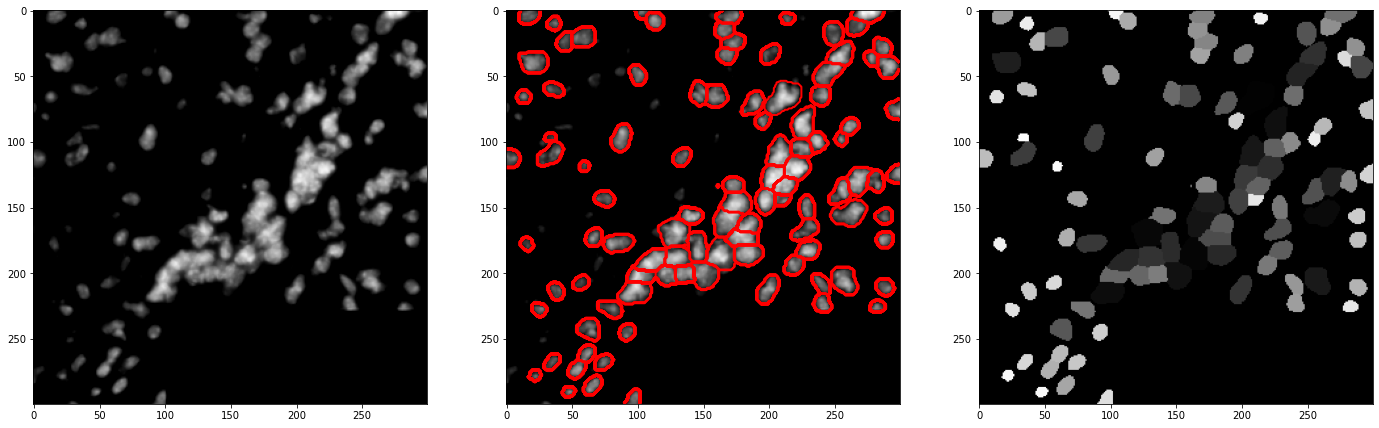

In [38]:
plot_mask_with_contours(segmask, raw_image)

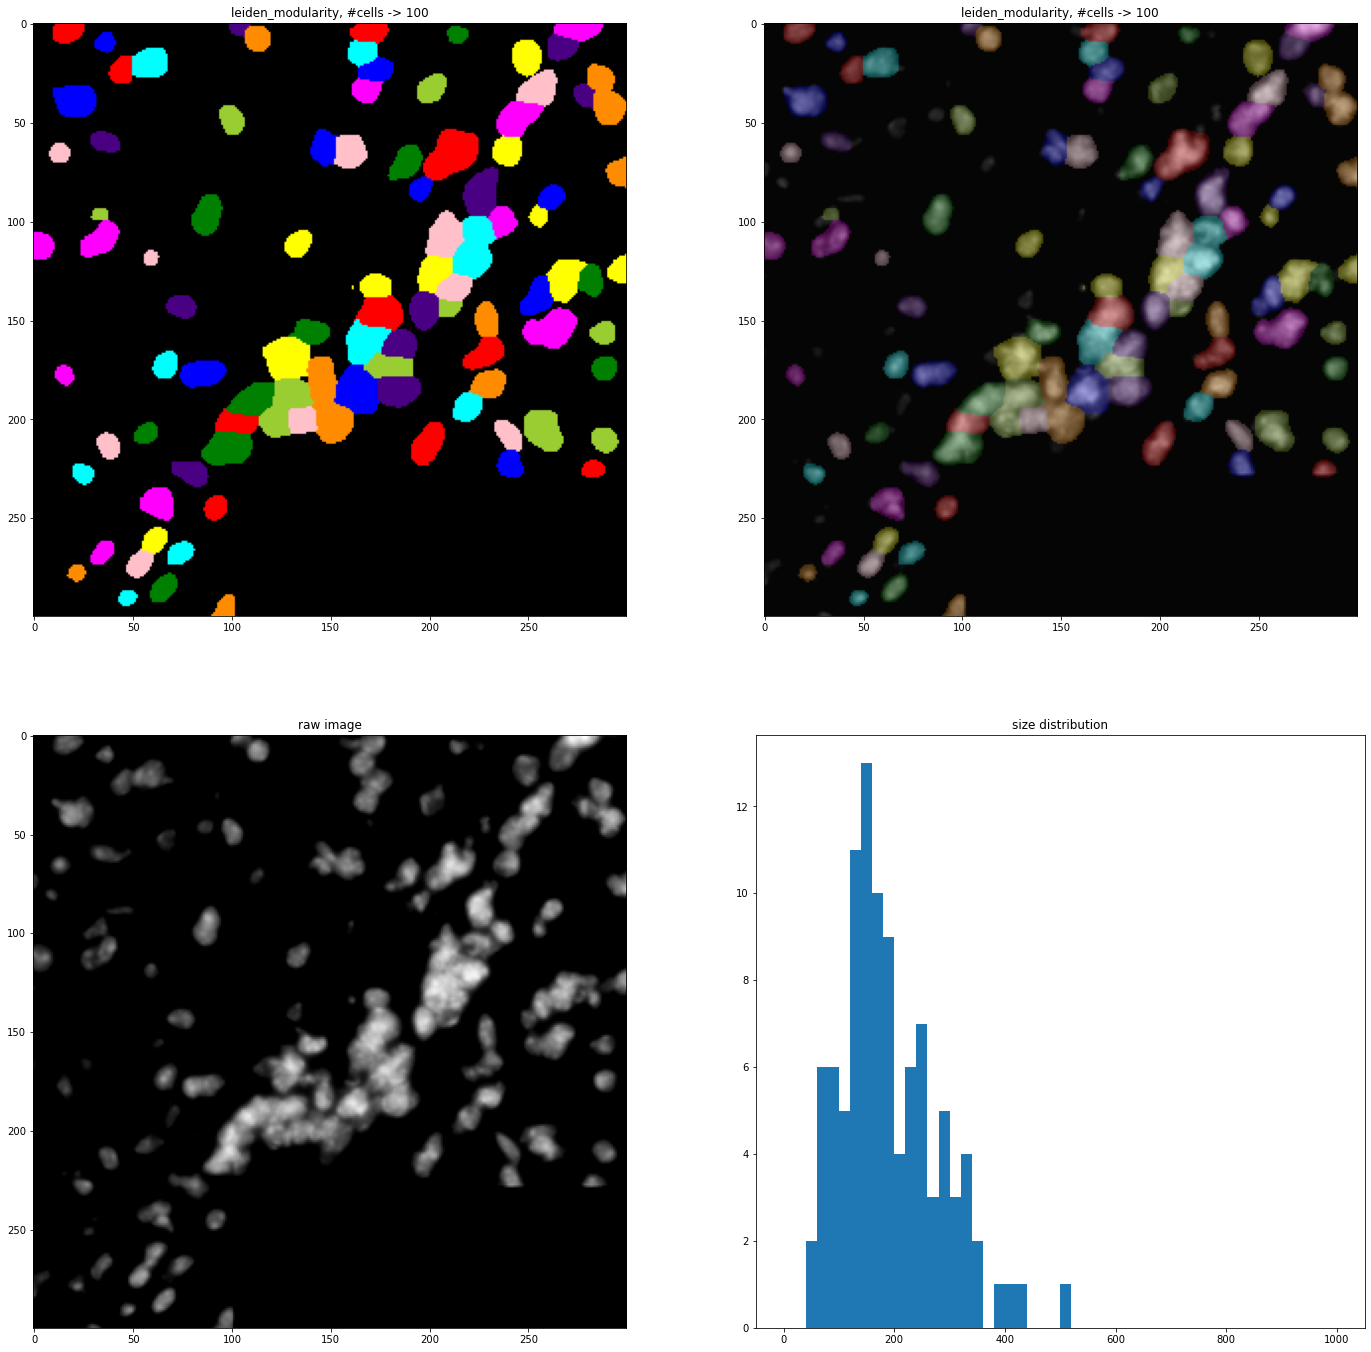

In [28]:
g.plot_partition(partition, window=window, figsize=(24, 24), bins=50, range=(0,1000))

In [ ]:
plt.imshow(segmask)

In [ ]:
import PIL.Image
pilobject = PIL.Image.fromarray(segmask)

